### Attention of Softmax(AGNews)

In [1]:
import pandas as pd
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import torch
import pickle
from torch import optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
filename = 'data/local_dict.pkl'
path = filename
dict_file = open(path, 'rb')

vocab  = pickle.load(dict_file)[0]
print('length of vocabulary: ',len(vocab))
dict_file.close()

filename = "data/Train.csv"
Train = pd.read_csv(filename)

length of vocabulary:  16174


In [3]:
vocab_size = 8000
text_length = 30
batch_size = 100
epoch_num = 100

word2idx = {'[PAD]':0}
for i, w in enumerate(vocab[:vocab_size]):
    word2idx[w] = i + 1
idx2word = {i: w for i, w in enumerate(word2idx)}

doc_list = Train['text'].to_list()
labels = Train['label'].astype('int').to_list()

In [4]:
from model import make_data
data = make_data(doc_list,word2idx,text_length)

In [5]:
len(data),len(labels)

(60000, 60000)

In [6]:
from model import MyDataSet

batch = Variable(torch.LongTensor(data))
labels = Variable(torch.LongTensor(labels))
loader = Data.DataLoader(MyDataSet(batch,labels), batch_size, True)

In [7]:
from model import SelfAttnClassifier

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

loss_function = nn.BCELoss()
model = SelfAttnClassifier(vocab_size+1, 200, 100, 1, scale=5.0,score_function='dot',activation='SoftMax')
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)

use_gpu = torch.cuda.is_available()

if(use_gpu):
    model = model.cuda()
    loss_function = loss_function.cuda()

In [8]:
model.train()
for epoch in tqdm(range(100)):
    for input_ids, label in loader:
        model.zero_grad()
        preds = model(input_ids.cuda())
        loss = loss_function(preds.squeeze(), label.cuda().float()) * 100
        loss.backward(retain_graph=True)
        optimizer.step()
        input_ids.cpu()
        label.cpu()

100%|██████████| 100/100 [09:02<00:00,  5.43s/it]


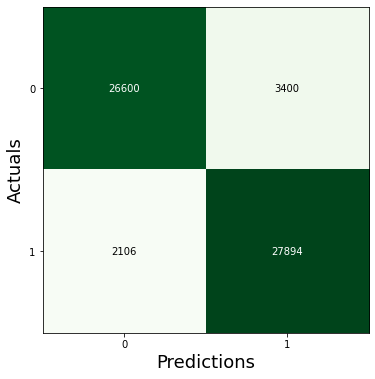

accuracy:90.823%


In [9]:
from model import plot_cm_matrix
plot_cm_matrix(model,batch,labels,save_url='graph/metric/SoftmaxTrainAcc.png')

### test accuracy

In [10]:
filename = "data/Test.csv"
Test = pd.read_csv(filename)

doc_list = Test['text'].to_list()
test_labels = Test['label'].astype('int').to_list()
    
test_data = make_data(doc_list,word2idx,text_length)
len(test_data),len(test_labels)

(3800, 3800)

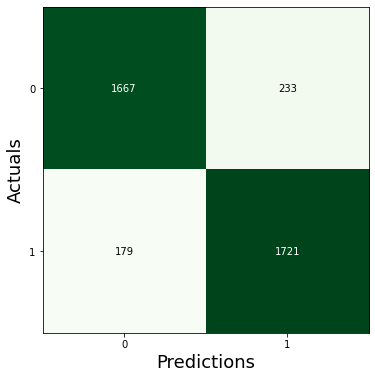

accuracy:89.158%


In [11]:
test_batch = Variable(torch.LongTensor(test_data))
test_labels = Variable(torch.LongTensor(test_labels))
plot_cm_matrix(model,test_batch,test_labels,save_url='graph/metric/picture3.png')

### Save Model

In [12]:
## 保存
torch.save(model.state_dict(), 'model/SoftmaxParameter.pkl')
torch.save(model, 'model/SoftmaxModel.pkl')

## 加载
#model = SelfAttnClassifier(vocab_size+1, 30, 10, 1, scale=5.0,score_function='dot',activation='SoftMax')
#model.load_state_dict(torch.load('model/SoftmaxParameter.pkl'))

# 加载
#model = torch.load('model/SoftmaxModel.pkl')

### Select Tokens

In [15]:
from model import SelectTokens
Pos,Neg,Neu = SelectTokens(data,labels,word2idx)

### Visualization

In [16]:
#from model import compute_coefficients
def compute_coefficients(model,batch,Pos,Neg,Neu,word2idx=None):
    idx2word = {i: w for i, w in enumerate(word2idx)}
    token_score = dict()
    token_weight = dict()
    num_dict = dict()
    for sample in batch:
        with torch.no_grad():
            seq_embs = model.embeddings(sample.cuda())

            Q = model.Wq(seq_embs)
            K = model.Wk(seq_embs)
            V = model.Wv(seq_embs)

            if model.score_function == 'dot':
                scores = (Q*K).sum(dim=-1) / model.scale
            elif model.score_function == 'additive':
                scores = torch.matmul(nn.Tanh()(K+Q),model.v).squeeze(-1)
            attn = model.activate(scores)
            sample.cpu()

            sent = sample.numpy().tolist()
            for i in range(len(sent)):
                word = idx2word[sent[i]]
                if word in token_score.keys():
                    token_score[word] += scores[i].cpu().detach().tolist()
                    token_weight[word] += attn[i].cpu().detach().tolist()
                    num_dict[word] += 1
                else:
                    token_score[word] = scores[i].cpu().detach().tolist()
                    token_weight[word] = attn[i].cpu().detach().tolist()
                    num_dict[word] = 1
                    
    pos_index = []
    pos_score = []
    pos_weight = []
    for tok in Pos:
        if tok in token_score.keys():
            if word2idx is None:
                num = num_dict[tok]
                pos_index.append(tok)
                pos_score.append(token_score[tok] / num)
                pos_weight.append(token_weight[tok] / num)
            else:
                num = num_dict[tok]
                pos_index.append(word2idx[tok])
                pos_score.append(token_score[tok] / num)
                pos_weight.append(token_weight[tok] / num)
            

    neg_index = []
    neg_score = []
    neg_weight = []
    for tok in Neg:
        if tok in token_score.keys():
            if word2idx is None:
                num = num_dict[tok]
                neg_index.append(tok)
                neg_score.append(token_score[tok] / num)
                neg_weight.append(token_weight[tok] / num)
            else:
                num = num_dict[tok]
                neg_index.append(word2idx[tok])
                neg_score.append(token_score[tok] / num)
                neg_weight.append(token_weight[tok] / num)

    neutral_index = []
    neutral_score = []
    neutral_weight = []
    for tok in Neu:
        if tok in token_score.keys():
            if word2idx is None:
                num = num_dict[tok]
                neutral_index.append(tok)
                neutral_score.append(token_score[tok] / num)
                neutral_weight.append(token_weight[tok] / num)
            else:
                num = num_dict[tok]
                neutral_index.append(word2idx[tok])
                neutral_score.append(token_score[tok] / num)
                neutral_weight.append(token_weight[tok] / num) 
            
    return pos_index,pos_score,pos_weight,neg_index,neg_score,neg_weight,neutral_index,neutral_score,neutral_weight

pos_index,pos_score,pos_weight,neg_index,neg_score,neg_weight,neutral_index,neutral_score,neutral_weight = compute_coefficients(model,batch,Pos,Neg,Neu,word2idx)

Pos Mean: -0.3707064681061327 Pos Std: 0.5626479870507171
Neg Mean: -0.28278925886346884 Neg Std: 0.7483009874971094
Neu Mean: -1.9267141350270707 Neu Std: 1.5653222462714003


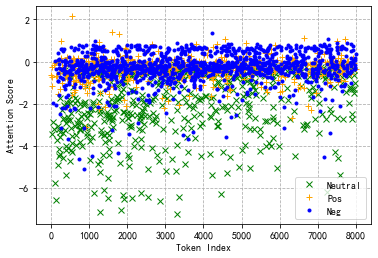

In [19]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_score, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_score, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_score, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Score')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture1.png')
print('Pos Mean:',np.mean(pos_score),'Pos Std:',np.std(pos_score))
print('Neg Mean:',np.mean(neg_score),'Neg Std:',np.std(neg_score))
print('Neu Mean:',np.mean(neutral_score),'Neu Std:',np.std(neutral_score))

Pos Mean: 0.22400952932309487 Pos Std: 0.07659601659359455
Neg Mean: 0.2501165850236288 Neg Std: 0.09342289920831096
Neu Mean: 0.12028853925566228 Neu Std: 0.13567869079936118


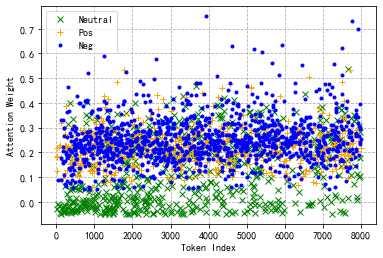

In [23]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_weight, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_weight, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_weight, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture2.png')
print('Pos Mean:',np.mean(pos_weight),'Pos Std:',np.std(pos_weight))
print('Neg Mean:',np.mean(neg_weight),'Neg Std:',np.std(neg_weight))
print('Neu Mean:',np.mean(neutral_weight),'Neu Std:',np.std(neutral_weight))

### Exp1--Feature Importance

3800it [00:08, 448.85it/s]


Both label
	p-value < 0.05: 1907  ratio: 0.5018421052631579
	p-value < 0.01: 1127  ratio: 0.29657894736842105
	Both-Mean: 0.2872691572712903 Std: 0.173862635641801

Pos
	p-value < 0.05: 854  ratio: 0.4494736842105263
	p-value < 0.01: 466  ratio: 0.24526315789473685
	Pos-Mean: 0.27011584103191155 Std: 0.17401890645921322

Neg
	p-value < 0.05: 1053  ratio: 0.5542105263157895
	p-value < 0.01: 661  ratio: 0.34789473684210526
	Neg-Mean: 0.3044224735106691 Std: 0.17200401106762198


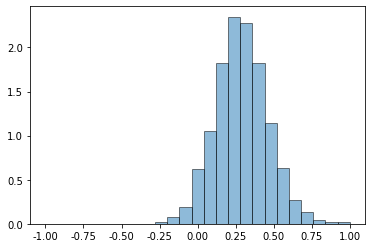

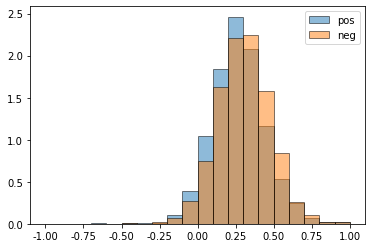

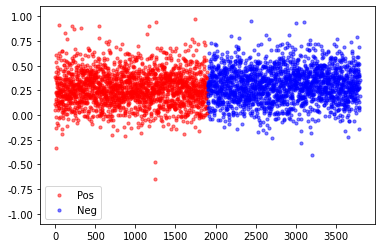

In [17]:
from model import GradientImportance
GradientImportance(model,test_batch,test_labels,'Softmax')

### Exp2--Feature Erasure

3800it [00:54, 70.16it/s]


Both label
	p-value < 0.05: 2002  ratio: 0.5268421052631579
	p-value < 0.01: 1397  ratio: 0.3676315789473684
	total num: 3800  mean: -0.018277974876981604  std: 0.3710882559405977
Pos
	p-value < 0.05: 927  ratio: 0.48789473684210527
	p-value < 0.01: 628  ratio: 0.33052631578947367
	total num: 1900  mean: 0.24703040795448764  std: 0.2531879675787838
Neg
	p-value < 0.05: 1075  ratio: 0.5657894736842105
	p-value < 0.01: 769  ratio: 0.4047368421052632
	total num: 1900  mean: -0.28358635770845075  std: 0.2655781701610563


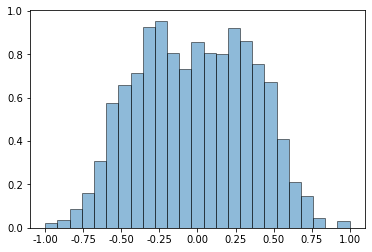

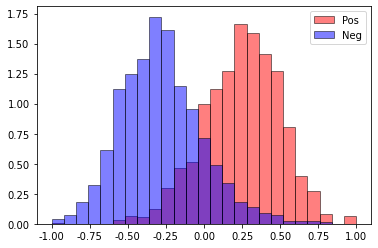

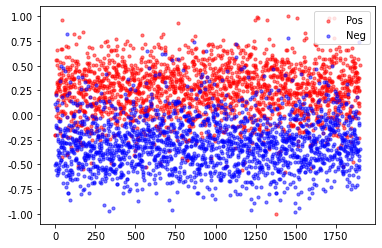

In [18]:
from model import FeatureErasure
FeatureErasure(model,test_batch,test_labels,'Softmax')

### Exp3--Feature Erasure ABS

3800it [00:56, 67.80it/s]


Both label
	p-value < 0.05: 3528  ratio: 0.9284210526315789
	p-value < 0.01: 3216  ratio: 0.8463157894736842
	total num: 3800  mean: 0.5427513668019617  std: 0.168010308008847
Pos
	p-value < 0.05: 1778  ratio: 0.9357894736842105
	p-value < 0.01: 1620  ratio: 0.8526315789473684
	total num: 1900  mean: 0.5473881075470863  std: 0.1675424891837872
Neg
	p-value < 0.05: 1750  ratio: 0.9210526315789473
	p-value < 0.01: 1596  ratio: 0.84
	total num: 1900  mean: 0.5381146260568369  std: 0.16834916923786947


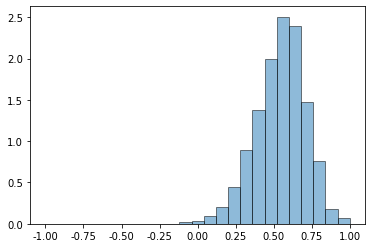

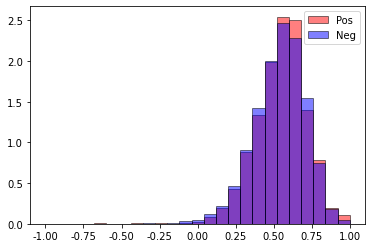

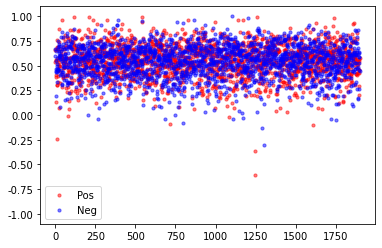

In [19]:
from model import FeatureErasureABS
FeatureErasureABS(model,test_batch,test_labels,'Softmax')

### Exp4--Attention Permutation

3800it [03:12, 19.78it/s]


Both label
	total num: 3800  mean: 0.23132122  std: 0.13171682
Pos
	total num: 1900  mean: 0.25035283  std: 0.13257028
Neg
	total num: 1900  mean: 0.21228962  std: 0.12805997


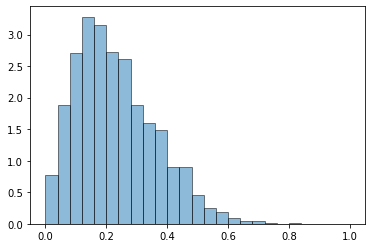

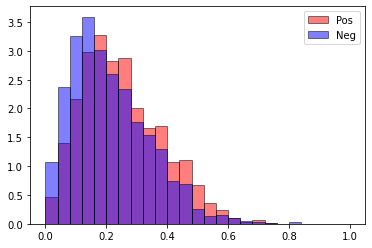

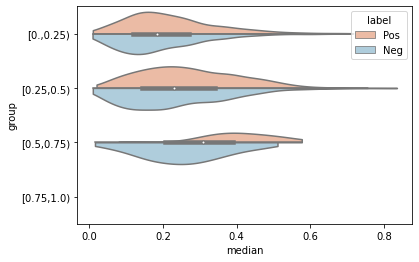

                  median                                                    \
                   count      mean       std       min       25%       50%   
label group                                                                  
Neg   [0.,0.25)    792.0  0.187852  0.115015  0.008444  0.102405  0.165596   
      [0.25,0.5)  1035.0  0.227883  0.135112  0.009164  0.121279  0.204581   
      [0.5,0.75)    73.0  0.256342  0.115043  0.015056  0.172465  0.251295   
Pos   [0.,0.25)    841.0  0.221204  0.124874  0.009171  0.132345  0.197224   
      [0.25,0.5)  1027.0  0.269564  0.132898  0.019300  0.167996  0.256529   
      [0.5,0.75)    32.0  0.399852  0.108323  0.079640  0.345234  0.408053   

                                      
                       75%       max  
label group                           
Neg   [0.,0.25)   0.255166  0.711556  
      [0.25,0.5)  0.320455  0.834898  
      [0.5,0.75)  0.326975  0.510618  
Pos   [0.,0.25)   0.281692  0.715898  
      [0.25,0.5)  0.3666

In [20]:
from model import AttnPermutation
AttnPermutation(model,test_batch,test_labels,'Softmax')

### Exp5--Attention Randomization

3800it [02:14, 28.15it/s]


Both label
	total num: 3800  mean: 0.14697547  std: 0.24513562
Pos
	total num: 1900  mean: 0.18125643  std: 0.27548173
Neg
	total num: 1900  mean: 0.11269453  std: 0.2047984


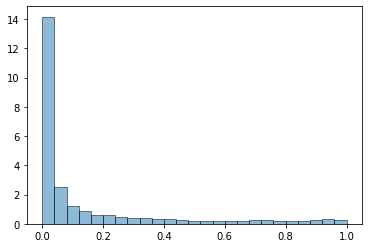

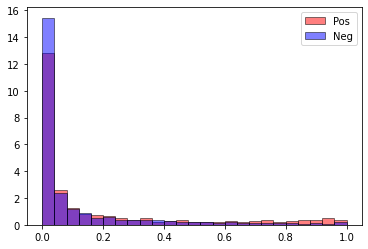

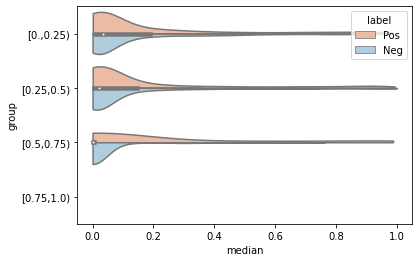

                  median                                                    \
                   count      mean       std       min       25%       50%   
label group                                                                  
Neg   [0.,0.25)    792.0  0.122435  0.194515  0.000056  0.006092  0.031634   
      [0.25,0.5)  1035.0  0.111168  0.216075  0.000011  0.002110  0.012972   
      [0.5,0.75)    73.0  0.028654  0.111399  0.000017  0.000107  0.000172   
Pos   [0.,0.25)    841.0  0.176993  0.262822  0.000738  0.011358  0.042406   
      [0.25,0.5)  1027.0  0.184047  0.283593  0.000549  0.008529  0.033903   
      [0.5,0.75)    32.0  0.203759  0.341368  0.000100  0.004022  0.005024   

                                      
                       75%       max  
label group                           
Neg   [0.,0.25)   0.142135  0.984387  
      [0.25,0.5)  0.094347  0.999490  
      [0.5,0.75)  0.000415  0.761440  
Pos   [0.,0.25)   0.225255  0.985913  
      [0.25,0.5)  0.2213

In [21]:
from model import AttnRandom
AttnRandom(model,test_batch,test_labels,'Softmax')

### check selected tokens

In [13]:
pos_df = pd.DataFrame(zip(pos_index,pos_score),columns=['index','value'])
pos_top_index = pos_df.sort_values(by='value',ascending=False)['index'].values[:50]
pos_top_words = []
for item in pos_top_index:
    pos_top_words.append(idx2word[item])
print(pos_top_words)
print(len(pos_df))

['disney', 'martha', 'snow', 'consumers', 'stock', 'barrel', 'bankrupt', 'entertainment', 'corporate', 'venture', 'ford', 'crude', 'higher', 'reliance', 'giant', 'inc', 'diva', 'marketing', 'stewart', 'levy', 'invest', 'commerce', 'attractive', 'auto', 'insurance', 'value', 'business', 'watts', 'warner', 'phones', 'average', 'likes', 'exploring', 'lynch', 'store', 'fields', 'presentation', 'malcolm', 'claude', 'disappointing', 'market', 'credit', 'diesel', 'com', 'managing', 'reap', 'p', 'animation', 'lows', 'exploration']
584


In [15]:
neg_df = pd.DataFrame(zip(neg_index,neg_score),columns=['index','value'])
neg_top_index = neg_df.sort_values(by='value',ascending=True)['index'].values[:50]
neg_top_words = []
for item in neg_top_index:
    neg_top_words.append(idx2word[item])
print(neg_top_words)
print(len(neg_df))

['car', 'rescue', 'others', 'howard', 'boy', 'school', 'authority', 'suspend', 'person', 'fierce', 'least', 'alleged', 'abandon', 'station', 'process', 'kenneth', 'sources', 'coal', 'innocent', 'fire', 'repeatedly', 'zone', 'operative', 'series', 'city', 'community', 'left', 'young', 'carry', 'shot', 'pressed', 'people', 'outside', 'hours', 'responsible', 'south', 'relative', 'apparently', 'north', 'his', 'france', 'indian', 'backed', 'powerful', 'defiant', 'foreign', 'plane', 'crisis', 'where', 'denied']
601


In [16]:
neu_df = pd.DataFrame(zip(neutral_index,neutral_score),columns=['index','value'])
neu_top_index1 = neu_df.sort_values(by='value',ascending=True)['index'].values[:50]
neu_top_index2 = neu_df.sort_values(by='value',ascending=False)['index'].values[:50]
neu_top_words = []
for item in neu_top_index1:
    neu_top_words.append(idx2word[item])
for item in neu_top_index2:
    neu_top_words.append(idx2word[item])
print(neu_top_words)
print(len(neu_df))

['talk', 'every', 'changes', 'later', 'beginning', 'term', 'pulled', 'details', 'date', 'millions', 'stay', 'pair', 'potentially', 'step', 'flying', 'effectively', 'norwegian', 'paper', 'should', 'drive', 'rivals', 'damage', 'fact', 'lack', 'age', 'prove', 'directly', 'shape', 'using', 'regain', 'advice', 'hoping', 'ends', 'followed', 'agent', 'nationwide', 'advance', 'unusual', 'finish', 'extra', 'sees', 'acting', 'find', 'decision', 'helping', 'exit', 'momentum', 'voice', 'gives', 'cold', 'intensely', 'aching', 'dedication', 'ruin', 'weighs', 'timer', 'interaction', 'kahn', 'pleasure', 'shirt', 'distraction', 'friendships', 'pleasing', 'steals', 'consummate', 'demographic', 'smartly', 'gender', 'schneider', 'chronicle', 'outsiders', 'tends', 'guessed', 'decency', 'bother', 'continuity', 'malaise', 'accumulated', 'roberts', 'distant', 'thrilling', 'minus', 'guess', 'burger', 'deja', 'curious', 'dust', 'damon', 'lends', 'consequence', 'conquer', 'scares', 'smack', 'uncomfortably', 'rel